# 📈 Volatility Forecasting with GARCH

In [48]:

import sys
import os
sys.path.append(os.path.abspath('../src'))


## Step 1: Load and Inspect Data

In [49]:

import importlib
import data_loader
importlib.reload(data_loader)



<module 'data_loader' from '/Users/vansh/Desktop/Uni/cs_projects/projects/volatility_forecasting_model/src/data_loader.py'>

In [50]:
from data_loader import fetch_price_data

df = fetch_price_data("AAPL", "2020-01-01", "2023-12-31")
print(df.columns)  # <— confirm what’s in there


[*********************100%***********************]  1 of 1 completed

MultiIndex([(  'Open', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            ( 'Close', 'AAPL'),
            ('Volume', 'AAPL')],
           )


In [51]:
from data_loader import fetch_price_data, compute_log_returns

ticker = 'META'
start_date = '2020-01-01'
end_date = '2023-12-31'

df = fetch_price_data(ticker, start_date, end_date)
price_series = df.loc[:, ('Adj Close', ticker)] if ('Adj Close', ticker) in df.columns else df.loc[:, ('Close', ticker)]
log_returns = compute_log_returns(price_series)

log_returns.tail()



[*********************100%***********************]  1 of 1 completed


Date
2023-12-22   -0.001979
2023-12-26    0.004066
2023-12-27    0.008419
2023-12-28    0.001369
2023-12-29   -0.012243
Name: (Close, META), dtype: float64

## Step 2: Fit GARCH(1,1) Model

In [52]:

from garch_model import fit_garch_model, forecast_volatility

garch_result = fit_garch_model(log_returns)
print(garch_result.summary())

forecast = forecast_volatility(garch_result, horizon=5)
print("5-day forecasted volatility:", forecast)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:      ('Close', 'META')   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2144.73
Distribution:                  Normal   AIC:                          -4281.46
Method:            Maximum Likelihood   BIC:                          -4261.81
                                        No. Observations:                 1005
Date:                Thu, Apr 17 2025   Df Residuals:                     1004
Time:                        12:00:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.6036e-05  1.502e-03  5.727e-02      0.954 

/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008958. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


## Step 3: Compare to Realized Volatility

/Users/vansh/Desktop/Uni/cs_projects/projects/volatility_forecasting_model/src/plotter.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/Users/vansh/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


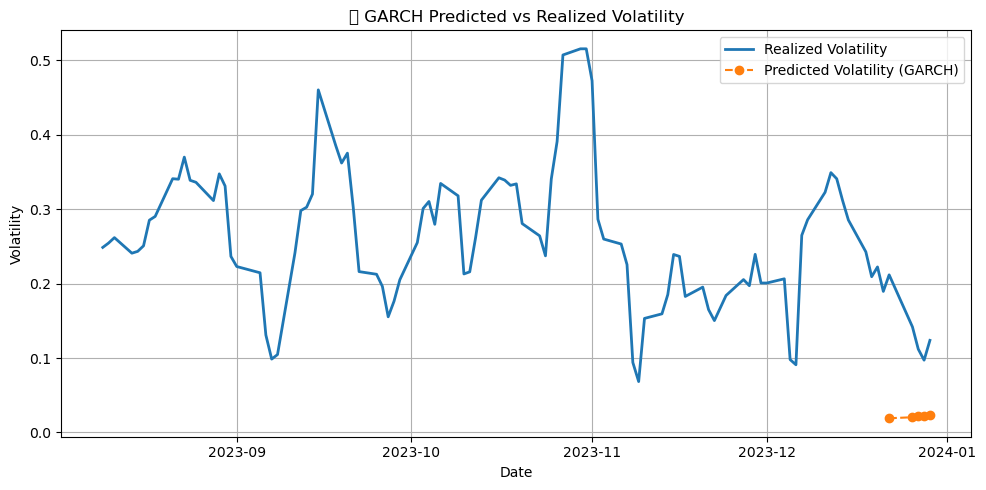

In [53]:

import numpy as np
import pandas as pd
realized_vol = log_returns.rolling(window=5).std() * np.sqrt(252)

# Create a predicted series for alignment
predicted_vol = pd.Series(forecast, index=realized_vol.index[-5:])

from plotter import plot_volatility_forecast
plot_volatility_forecast(realized_vol[-100:], predicted_vol)


## Step 4: Sensitivity Analysis

/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008958. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008958. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/vansh/anaconda3/lib/python3.11/site-packages/arch/u

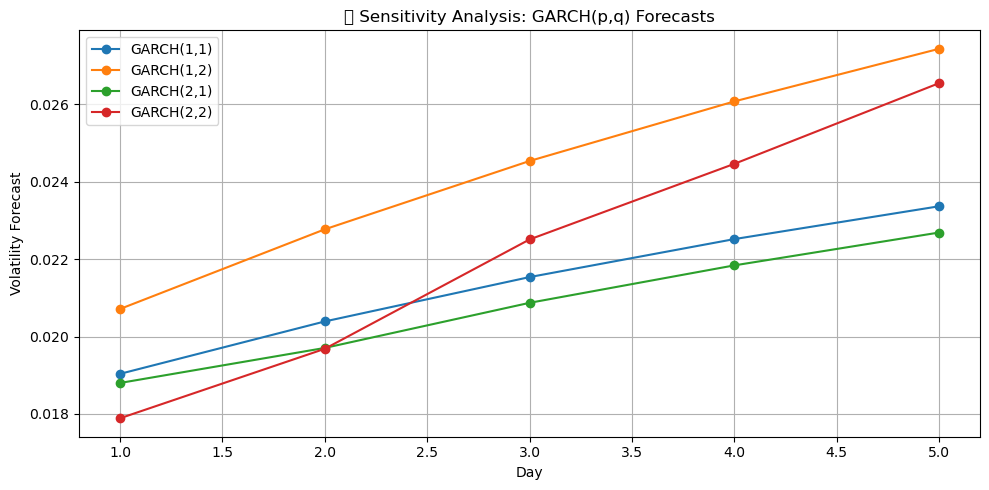

In [54]:

from arch import arch_model
from plotter import plot_sensitivity_analysis

params = [(1,1), (1,2), (2,1), (2,2)]
forecasts = {}

for p, q in params:
    model = arch_model(log_returns, vol='Garch', p=p, q=q)
    res = model.fit(disp='off')
    f = res.forecast(horizon=5).variance.values[-1] ** 0.5
    forecasts[(p, q)] = f

plot_sensitivity_analysis(forecasts)
